# Wall of imports

In [1]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import pandas as pd

import numpy as np

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
%matplotlib widget

from tqdm import tqdm

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Normalizer

RANDOM_SEED = None

from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.linalg import Vectors

from functools import reduce

import json

from pyspark.ml.regression import LinearRegression

from pyspark_dist_explore import hist

from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.regression import DecisionTreeRegressor

from pyspark.ml import Pipeline

from pyspark.ml.tuning import ParamGridBuilder

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import GBTRegressor

from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from operator import itemgetter

from pyspark.ml.feature import MinMaxScaler

from pyspark.ml.linalg import Vectors, VectorUDT

from pyspark.ml.stat import Summarizer

from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA

from pyspark.ml.feature import UnivariateFeatureSelector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import FunctionTransformer


import warnings # supress warnings
warnings.filterwarnings('ignore')

# Spark

In [2]:
conf = (
    SparkConf()
    .set("spark.ui.port", "4050")
    .set("spark.executor.memory", "4G")
    .set("spark.driver.memory", "20G")
    .set("spark.driver.maxResultSize", "10G")
)
# .set("spark.master", "spark://192.168.1.189:4050")


# create the context
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")


spark = SparkSession.builder.getOrCreate()

22/06/09 16:29:12 WARN Utils: Your hostname, RTX-2070-Rig resolves to a loopback address: 127.0.1.1; using 192.168.1.189 instead (on interface wlp7s0)
22/06/09 16:29:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/09 16:29:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading football players

In [3]:
modern_df = spark.read.csv(
    "data/players_*.csv", sep=",", inferSchema=True, header=True, multiLine=True
)

legacy_df = spark.read.csv(
    "data/scraped_players_*.csv", sep=",", inferSchema=True, header=True, 
    multiLine=True
)

# Pre-processing football players

In [4]:
leagues = [
    "Spain Primera Division",
    "German 1. Bundesliga",
    "French Ligue 1",
    "English Premier League",
    "Italian Serie A",
    "Holland Eredivisie",
]

seasons_modern = ["20", "19", "18", "17", "16", "15", "14"] 
seasons_legacy = ["13", "12", "11", "10", "09", "08", "07"]
# seasons_legacy = [  ]
seasons = seasons_legacy + seasons_modern

# football_teams = [
#     row["club_name"] for row in modern_df.select(
#         "club_name"
#     ).distinct().collect()
# ]

columns = [
    "short_name",
    "club_name",
    "league_name",
    "season",
    "player_positions",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

def get_season(url):
    url_split = url.split("/")

    # -1 to scale FIFA years down, to have compatibility with all_tables_fixed
    return str(
        (int(url_split[-2 if url_split[-1] == "" else -1][0:2]) - 1)
    ).zfill(2)


get_season_UDF = udf(lambda url: get_season(url), StringType())

roles_to_macro_role_UDF = udf(
    lambda roles: float(roles_to_macro_roles_dict[roles.split(",")[0]]), StringType()
)

In [5]:
pre_processed_modern_df = modern_df.dropDuplicates(["player_url"])
pre_processed_legacy_df = legacy_df.dropDuplicates(["player_url"])

pre_processed_modern_df = pre_processed_modern_df.filter(col("player_positions") != "GK")
pre_processed_legacy_df = pre_processed_legacy_df.filter(col("player_positions") != "GK")

pre_processed_modern_df = pre_processed_modern_df.na.fill(0)
pre_processed_legacy_df = pre_processed_legacy_df.na.fill(0)

pre_processed_modern_df = pre_processed_modern_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)

pre_processed_modern_df = pre_processed_modern_df.where(
    (pre_processed_modern_df.league_name.isin(leagues))
    &
    (pre_processed_modern_df.season.isin(seasons_modern))
)
pre_processed_legacy_df = pre_processed_legacy_df.where(
    (pre_processed_legacy_df.league_name.isin(leagues))
    &
    (pre_processed_legacy_df.season.isin(seasons_legacy))
)

pre_processed_modern_df = pre_processed_modern_df.select(columns)

# TODO use a for loop
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pas", "passing"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "dri", "dribbling"
)
pre_processed_legacy_df = pre_processed_legacy_df.drop(col("defending"))

pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "def", "defending"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "phy", "physic"
)

pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "sho", "shooting"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pac", "pace"
)

pre_processed_legacy_df = pre_processed_legacy_df.select(columns)

In [6]:
pre_processed_df = pre_processed_modern_df.unionByName(
    pre_processed_legacy_df
)


# Building football teams

In [7]:
football_teams_df = pre_processed_df

In [8]:
PLAYER_FEATURES = [
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

PLAYER_FEATURES_AVG = [
    "avg(" + player_feature + ")" for player_feature in PLAYER_FEATURES
]

TARGET_VARIABLE = "points"

In [9]:
football_teams_df = football_teams_df.select(
    "season", "club_name", *PLAYER_FEATURES
).groupBy(
    ["season", "club_name"]
).agg(
    { player_feature: "avg" for player_feature in PLAYER_FEATURES }
)

# Loading football teams seasonal scores

In [10]:
seasonal_scores_df = (
    spark.read.csv(
        "data/all_tables_fixed_renamed_leagues.csv",
        sep=",",
        inferSchema=True,
        header=True,
        multiLine=True,
    )
    .withColumnRenamed("Year", "year")
    .withColumnRenamed("Team", "club_name_abbr")
    .withColumnRenamed("P", "points")
    .withColumnRenamed("Place", "place")
    .withColumnRenamed("League", "league")
)

# Pre-processing football teams seasonal scores

In [11]:
seasonal_scores_columns = [
    "year", "club_name_abbr", "points", "place", "league"
]

f = open("data/clubs_map.json")
club_name_abbr_to_ext = json.load(f)
f.close()

abbreviate_season_UDF = udf(
    lambda season: str(season)[-2:],
    StringType(),
)

def extend_club_name(club_name_abbr):
    try:
        return club_name_abbr_to_ext[club_name_abbr]
    except KeyError as e:
        return "NOT_FOUND"
    except Exception as e:
        return "GENERAL_EXCEPTION"

extend_club_name_UDF = udf(
    lambda club_name_abbr: extend_club_name(str(club_name_abbr)),
    StringType(),
)

In [12]:
pre_processed_seasonal_scores_df = seasonal_scores_df

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.dropDuplicates(
    seasonal_scores_columns
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.na.fill(0)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.select(
    seasonal_scores_columns
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "year", abbreviate_season_UDF(col("year"))
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "club_name_ext", extend_club_name_UDF(col("club_name_abbr"))
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "points", pre_processed_seasonal_scores_df.points.cast(DoubleType())
)

if pre_processed_seasonal_scores_df.filter(
    col("club_name_ext") == "NOT_FOUND"
).count() > 0:
    print("WARN: some clubs have NOT been found")
    print("Please check your data")

In [13]:
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.where(
    (pre_processed_seasonal_scores_df.year.isin(seasons))
    & (pre_processed_seasonal_scores_df.league.isin(leagues))
)

In [14]:
seasonal_scores_pre_join_columns = [
    "year", "league", "club_name_ext", "points", "place"
]

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.select(
    seasonal_scores_pre_join_columns
)

# Joining football teams features with their seasonal scores

In [15]:
df = football_teams_df.join(
    pre_processed_seasonal_scores_df,
    (football_teams_df.season == pre_processed_seasonal_scores_df.year)
    & (
        football_teams_df.club_name
        == pre_processed_seasonal_scores_df.club_name_ext
    ),
)

In [16]:
if pre_processed_seasonal_scores_df.select("club_name_ext").distinct().subtract(
    df.select("club_name_ext").distinct()
).count() > 0:
    print("WARN: Some football teams have been left out the join (pre_processed_seasonal_scores_df)")
    print("Please, check your data!")

if football_teams_df.select("club_name").distinct().subtract(
    df.select("club_name_ext").distinct()
).count() > 0:
    print("WARN: Some football teams have been left out the join (football_teams_df)")
    print("Please, check your data!")

# Feature assembling

In [17]:
assembler = VectorAssembler(
    inputCols=PLAYER_FEATURES_AVG, outputCol="feature_vec"
)

df = assembler.transform(df)

# Commodity methods

In [18]:
def plot_feature_target_relation(
    data, x, y, n_rows = 12, n_cols = 2, figsize = (20, 40), color = "#000000"
):

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for x_ind, x_value in enumerate(x):
        ax = sns.regplot(
            data=pdf,
            x=x_value,
            y=y,
            color = color,
            ax=axes[x_ind // n_cols, x_ind % n_cols],
        )


    fig.tight_layout(pad=1.5)

In [42]:
def plot_feature_distribution(
    data, features, n_rows = 12, n_cols = 2, figsize = (20, 40), 
    color = "#000000"
):

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 30))

    for feature_ind, feature in enumerate(features):
        _ = sns.histplot(
            data[feature],
            kde=True,
            color=color,
            facecolor=color,
            ax=axes[feature_ind // n_cols, feature_ind % n_cols],
        )

    fig.tight_layout(pad=1.5)

In [20]:
def plot_correlation_matrix(
    data, features, title = "Pearson Correlation Matrix", figsize = (16,12)
):

    mask = np.zeros_like(data[features].corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):  # Temporarily set the background to white
        fig, ax = plt.subplots(figsize=figsize)
        plt.title(title, fontsize=24)

        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        _ = sns.heatmap(
            data[features].corr(),
            linewidths=0.25,
            vmax=0.7,
            square=True,
            ax=ax,
            cmap=cmap,
            linecolor="w",
            annot=True,
            annot_kws={"size": 8},
            mask=mask,
            cbar_kws={"shrink": 0.9},
        )

# Raw data

In [21]:
COLOR_RAW = "#332FD0"

*[explain what does "raw" mean]*

## Visualizations

In [82]:
pdf = df.toPandas()

### Feature-target correlation

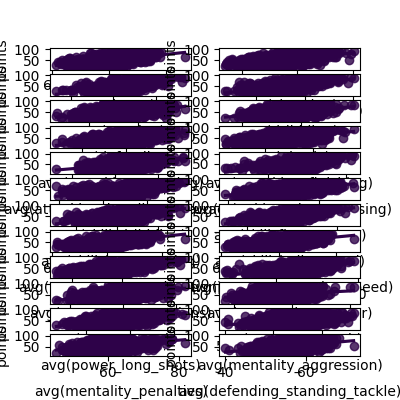

In [83]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, PLAYER_FEATURES_AVG, TARGET_VARIABLE, figsize=(4,4), color=COLOR_RAW
)

### Feature distribution

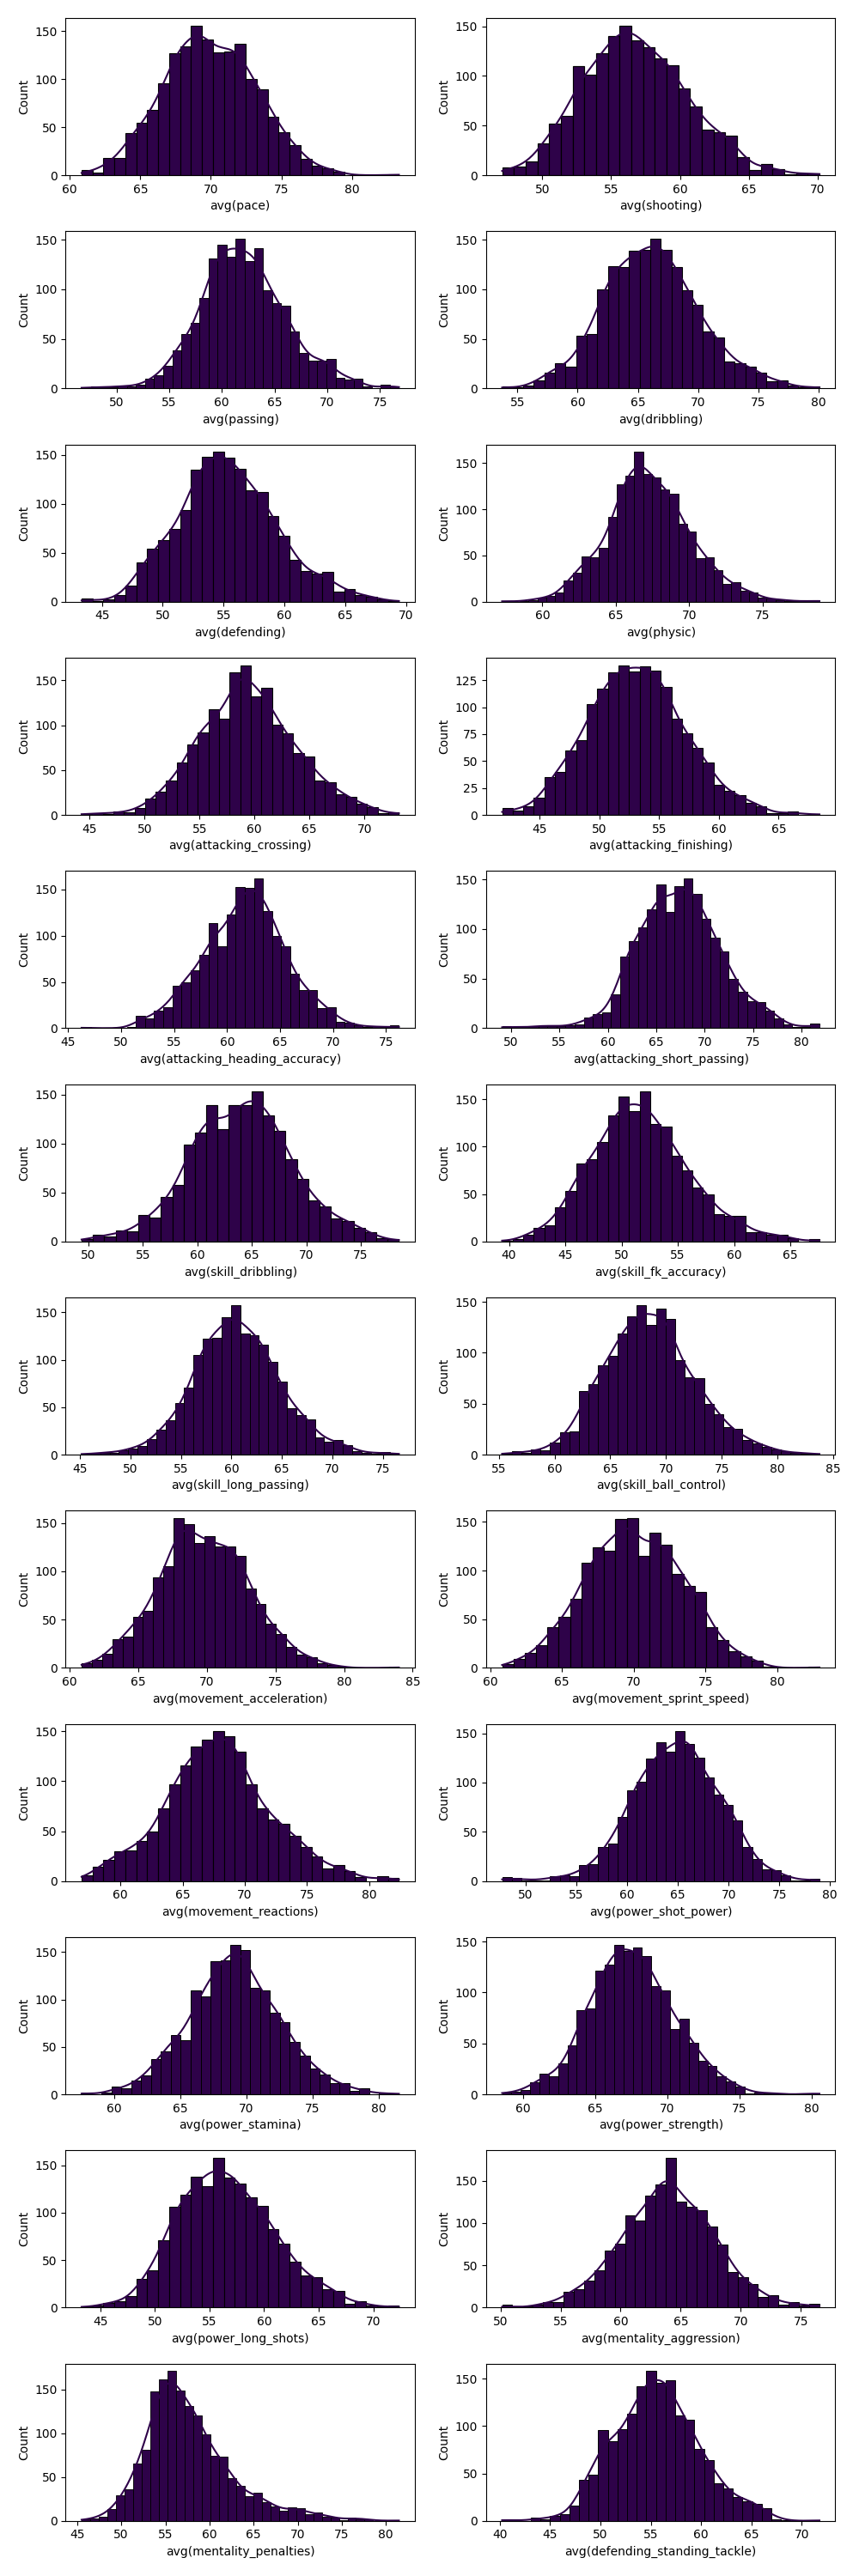

In [84]:
plot_feature_distribution(pdf, PLAYER_FEATURES_AVG, color = COLOR_RAW, figsize=(10,10))

### Pearson Correlation Matrix

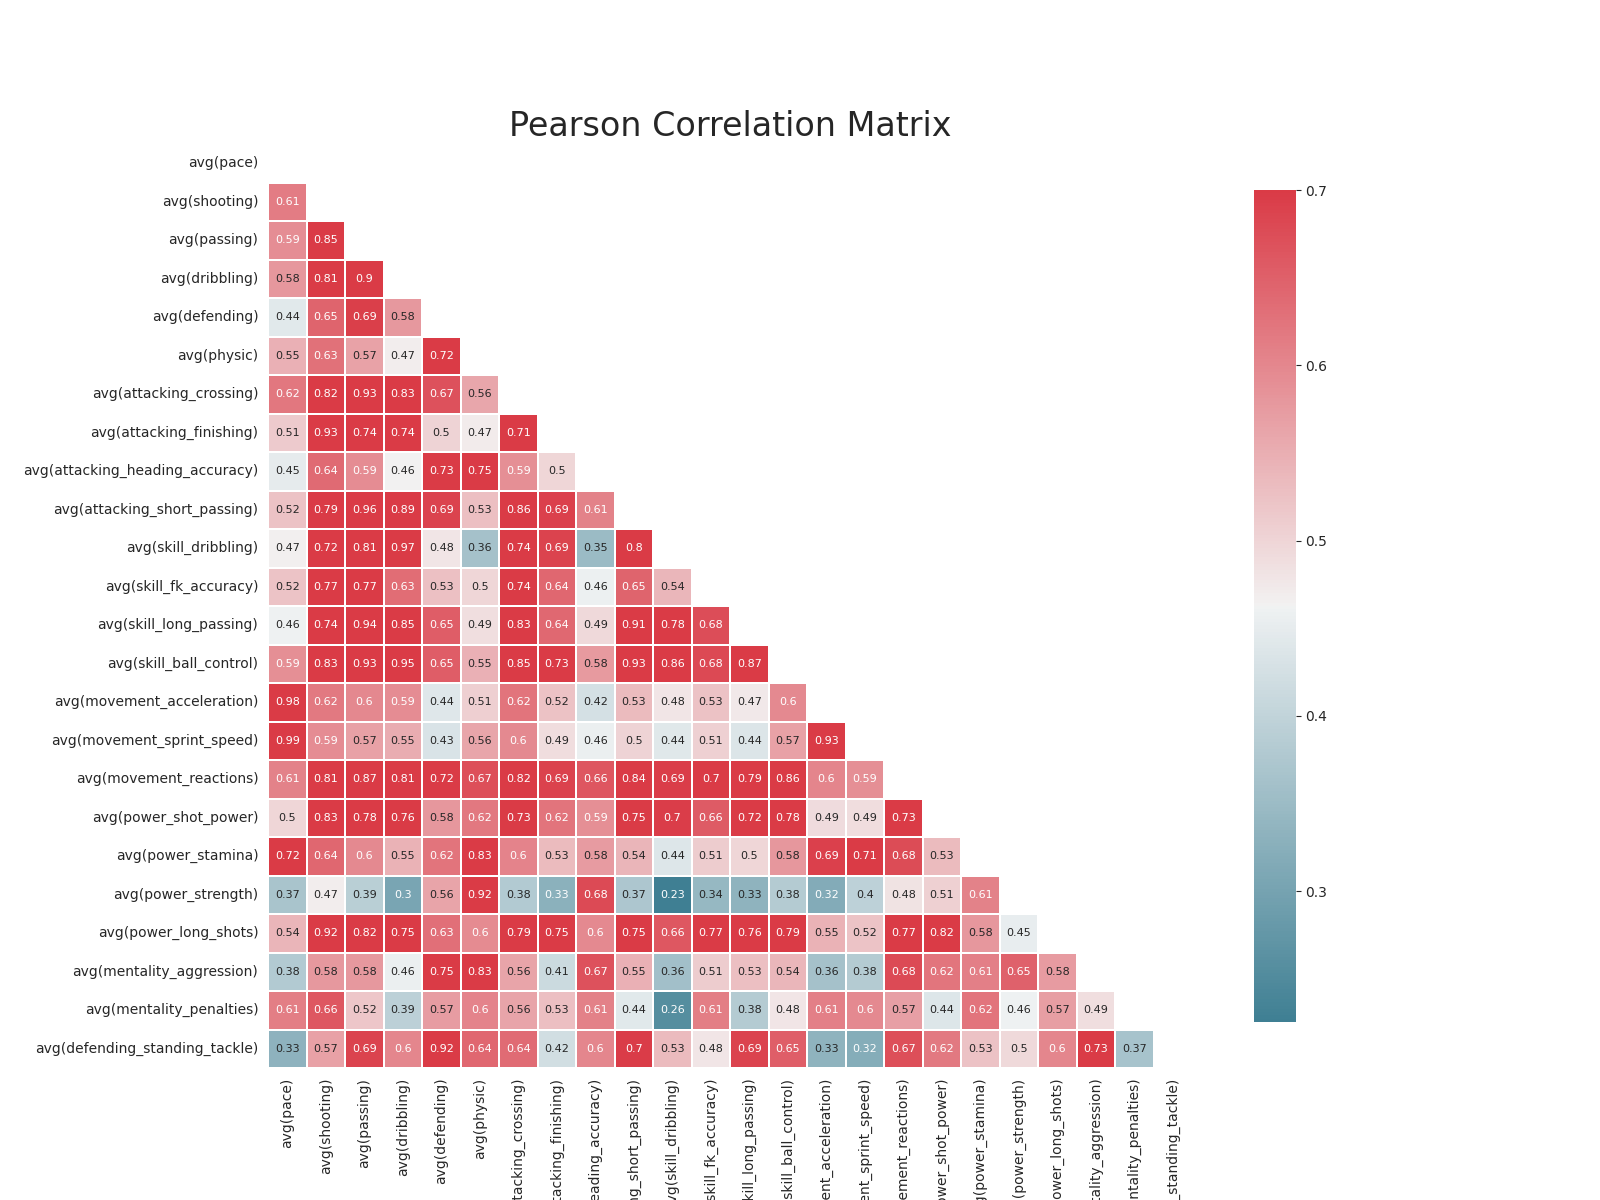

In [85]:
plot_correlation_matrix(pdf, PLAYER_FEATURES_AVG)

# Normalized data

Since we have some features with skewed distributions, we'll try normalizations that usually help in such setting

## Standardization

In [86]:
standardized_df = df

In [87]:
scaler = StandardScaler(
    inputCol="feature_vec", 
    outputCol="feature_vec_std", 
    withStd=True, 
    withMean=True
)

In [88]:
standardized_df = scaler.fit(standardized_df).transform(standardized_df)

In [89]:
COLOR_STD = "#9254C8"

PLAYER_FEATURES_AVG_STD = [
    player_feature + "_std" for player_feature in PLAYER_FEATURES_AVG
]

## Visualizations

In [90]:
pdf = standardized_df.toPandas()

In [91]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + PLAYER_FEATURES_AVG_STD
)

pdf[PLAYER_FEATURES_AVG_STD] = pdf[
    "feature_vec_std"
].transform(
    {
        PLAYER_FEATURES_AVG_STD[i]: itemgetter(i) for i, p in enumerate(PLAYER_FEATURES_AVG_STD)
    }

    
)

### Feature-target correlation

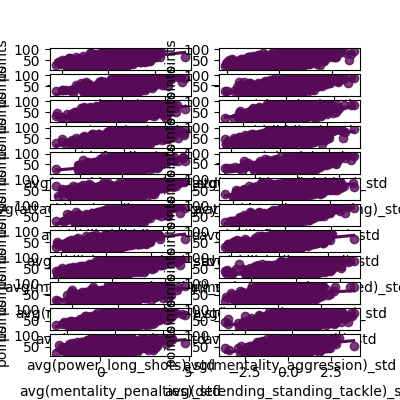

In [92]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, PLAYER_FEATURES_AVG_STD, TARGET_VARIABLE, figsize=(4,4), color=COLOR_STD
)

### Feature distribution

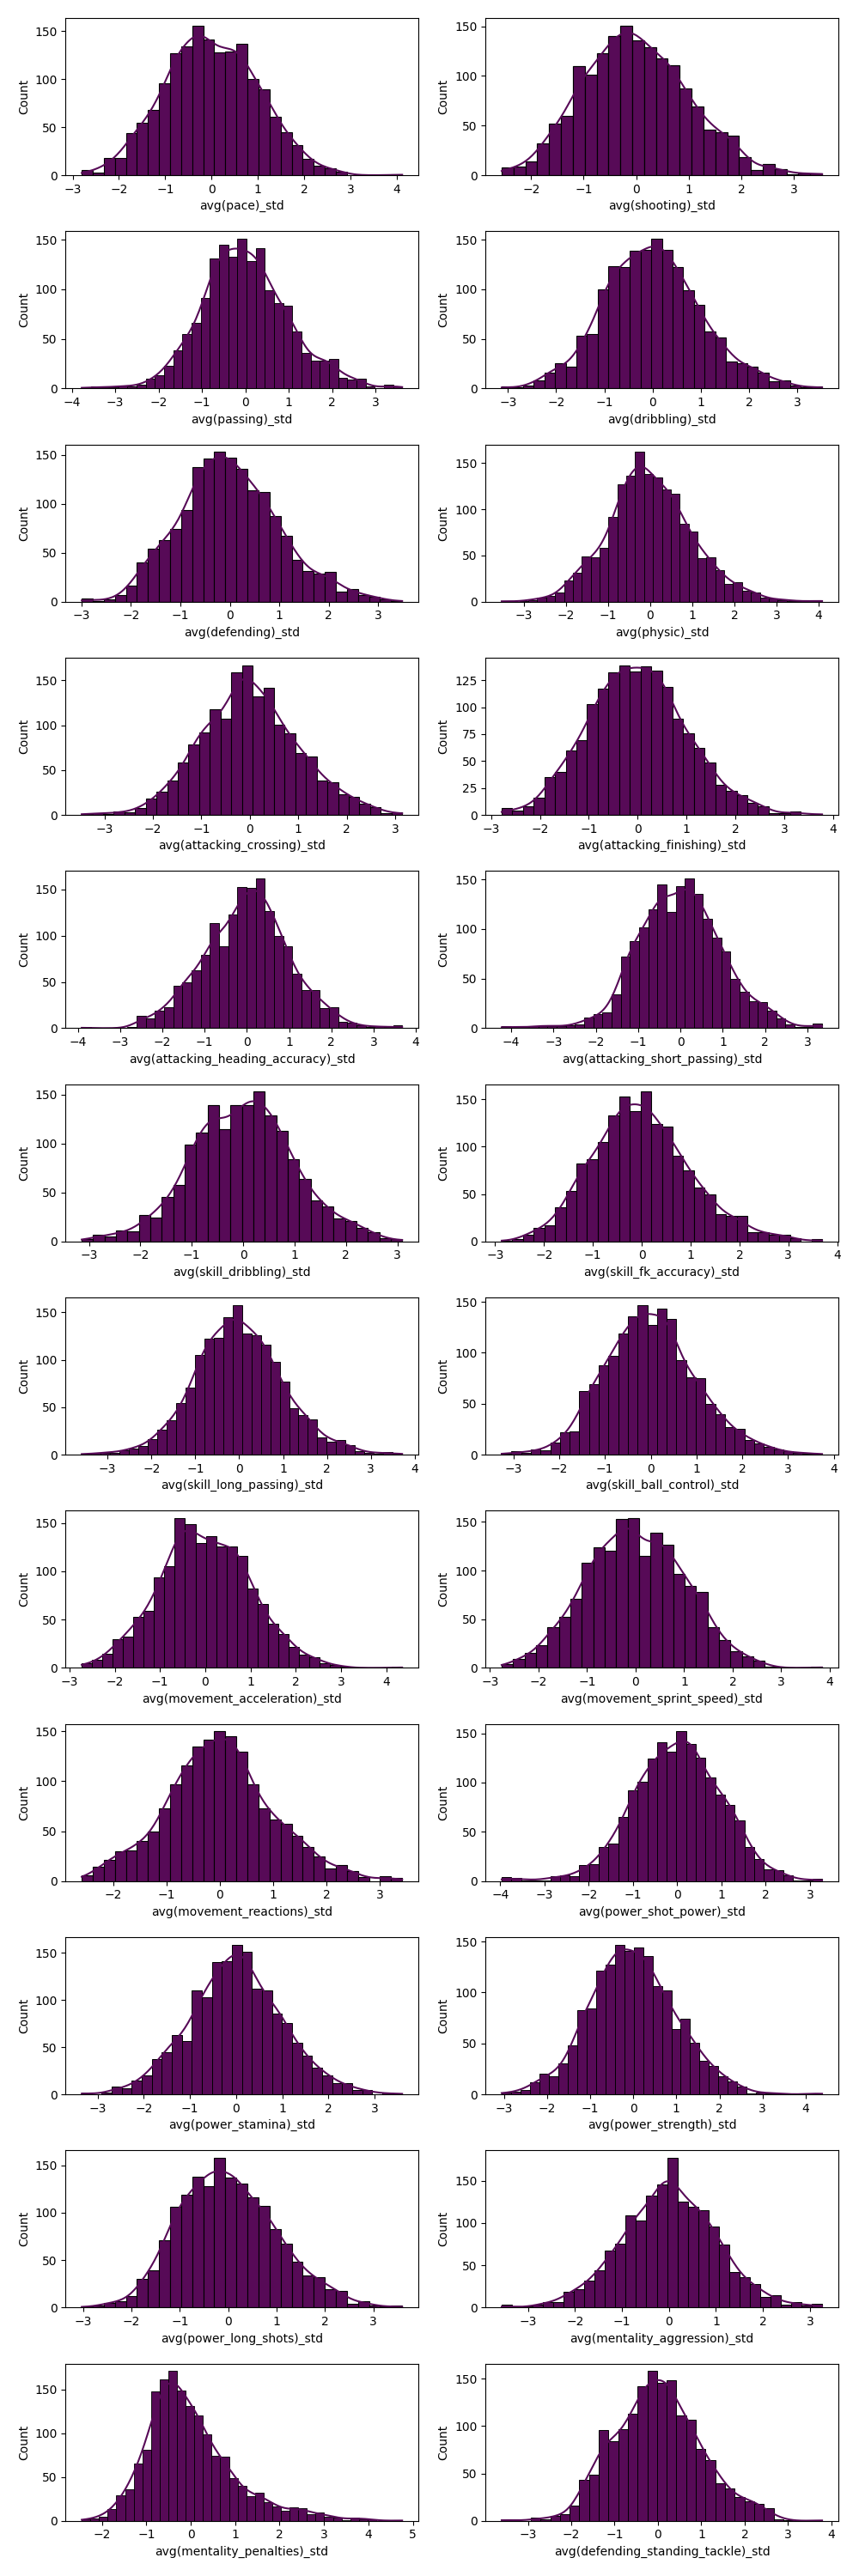

In [93]:
plot_feature_distribution(pdf, PLAYER_FEATURES_AVG_STD, color = COLOR_STD, figsize=(10,10))

## Log transformation

In [94]:
log_df = df

In [95]:
PLAYER_FEATURES_AVG_LOG = [
    player_feature + "_log" for player_feature in PLAYER_FEATURES_AVG
]

COLOR_LOG = "#E15FED"

In [96]:
to_log_UDF = udf(
    lambda value: float(np.log2(value)), DoubleType()
)

In [97]:
for f, fl in zip(PLAYER_FEATURES_AVG, PLAYER_FEATURES_AVG_LOG):
    log_df = log_df.withColumn(fl, to_log_UDF(col(f)))

### Visualizations

In [98]:
pdf = log_df.toPandas()

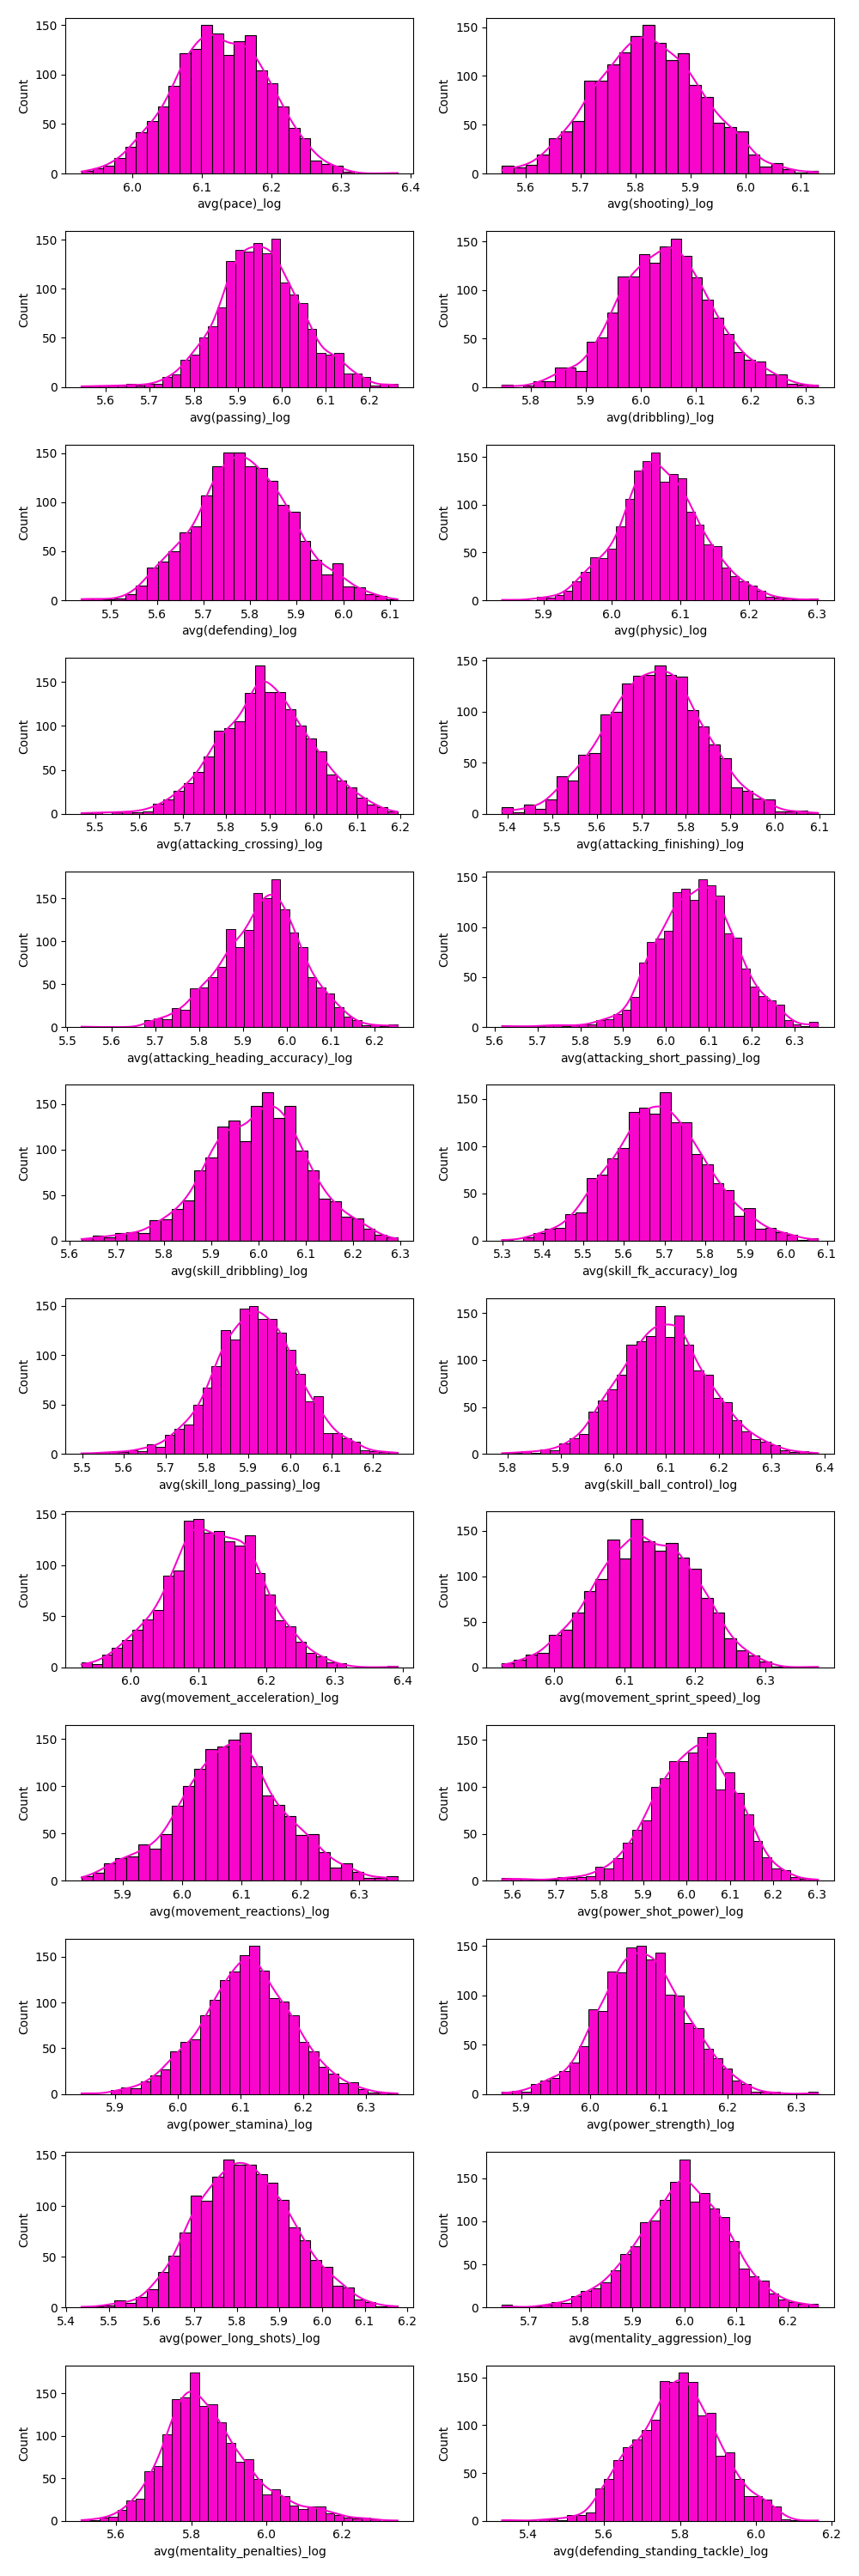

In [99]:
plot_feature_distribution(pdf, PLAYER_FEATURES_AVG_LOG, color = COLOR_LOG, figsize=(10,10))

## Min-max transformation

In [104]:
min_max_df = df

In [ ]:
PLAYER_FEATURES_AVG_MIN_MAX = [
    player_feature + "_min_max" for player_feature in PLAYER_FEATURES_AVG
]

COLOR_LOG = "#6EDCD9"

In [ ]:
scaler = MinMaxScaler(
    inputCol="feature_vec", 
    outputCol="feature_vec_min_max", 
    withStd=True, 
    withMean=True
)

## Feature selection

In [100]:
raw_feature_selection_df = df

In [101]:
selector = UnivariateFeatureSelector(
    featuresCol="feature_vec",
    labelCol=TARGET_VARIABLE, 
    selectionMode="percentile"
).setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(0.1)

In [102]:
fit_result = dict()

# for thr in range(0.1, 1.1, 0.1):
for thr in np.linspace(1, 1, 1):

    selector.setSelectionThreshold(thr)
    selector.setOutputCol("feature_vec_ufs_" + str(thr)),
    fit_result[str(thr)] = selector.fit(df)
    raw_feature_selection_df = fit_result[str(thr)].transform(
        raw_feature_selection_df
    )


## Learning

In [103]:
raw_learning_df = raw_feature_selection_df

### Linear Regression